# Data augmentation

> Custom data augmentation techniques to be applied to input images.

In [ ]:
#| default_exp augment

In [ ]:
#| export
from fastai.data.all import *
from fastai.vision.all import *
import numpy as np

In [ ]:
#| exports
@delegates()
class Quantize(RandTransform):
    "Quantize B&W image."
    split_idx = None
    def __init__(self, 
        n_valid: int, # Validation set size
        **kwargs
    ):
        store_attr()
        super().__init__(**kwargs)
        self.valid_percentiles = [self.get_random_percentiles() for i in range(n_valid)]
        self.valid_idx = 0

    def before_call(self, 
        b, 
        split_idx:int # Index of the train/valid dataset (0: train, 1: valid)
    ):
        self.idx = split_idx
        
    def get_random_percentiles(self):
        start = np.random.uniform(1, 50)
        end = np.random.uniform(90.1, 99.5)
        steps = np.random.randint(5, 100)
        return torch.linspace(start=start, end=end, steps=steps)

    def get_percentiles(self):
        if self.idx == 1:
            percentiles = self.valid_percentiles[self.valid_idx%self.n_valid]
            self.valid_idx += 1
            return percentiles
        else:
            return self.get_random_percentiles()
    
    def encodes(self, x:Image.Image):
        im_tensor = image2tensor(x)[0, :, :]
        percentiles = self.get_percentiles()
        levels = torch.quantile(im_tensor.float(), percentiles / 100)
        im_quant = torch.bucketize(im_tensor.float(), levels)
        
        cmap = plt.get_cmap('Spectral_r')
        im_color = tensor(cmap(im_quant.float() / im_quant.max())[:,:,:3])
        im_color = im_color.permute(2, 0, 1)
        return to_image(im_color)

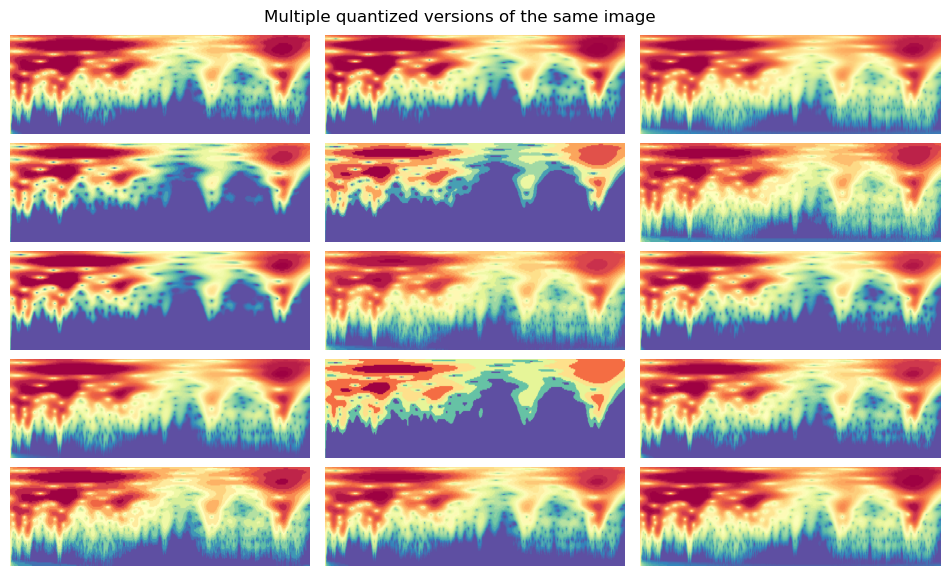

In [ ]:
#| eval = False
im_path = '../_data/all-grey-255.png'
im = PILImage.create(im_path)

fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(5, 3, hspace=0.01, wspace=0.05)
axs = gs.subplots()

for ax in axs.flatten():
    quantized_im = Quantize(n_valid=1)(im)
    ax.imshow(quantized_im)
    ax.axis('off')

fig.suptitle('Multiple quantized versions of the same image', fontsize=12, y=0.91)
plt.show()